In [83]:
import pandas as pd
import numpy as np
import requests
%matplotlib inline

In [84]:
tokens = ['ETH','SOL','AVAX','USDT','FLOW']

In [85]:
def get_data(token):
    res = requests.get(
        f'https://api.cryptowat.ch/markets/coinbase-pro/{token}usd/ohlc',
        params={
            'periods': '3600',
            'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
        }
    )
    
    if res.json().get('error',0)!=0:
        res = requests.get(
            f'https://api.cryptowat.ch/markets/kraken/{token}usd/ohlc',
            params={
                'periods': '3600',
                'after': str(int(pd.Timestamp('2021-11-22').timestamp()))
            }
        )
        
    
    df = pd.DataFrame(
        res.json()['result']['3600'],
        columns=['ts', 'open', 'high', 'low', 'close', 'volume', 'volumeUSD']
    )
    df['ts'] = pd.to_datetime(df.ts, unit='s')
    df['token'] = token
    
    return df


In [90]:
df_lis = [get_data(token) for token in tokens]
df = pd.concat(df_lis,axis=0)

In [91]:
#question 1:Get the total USD volume traded for each token in a dataframe, sorted from highest volume to lowest volume
total_volume_USD = df.groupby('token')['volumeUSD'].agg(np.sum).sort_values(ascending=False).to_frame()
total_volume_USD

,volumeUSD
token,
ETH,2.101416e+10
SOL,6.865458e+09
AVAX,3.417062e+09
USDT,1.967138e+09
FLOW,8.607774e+07


In [92]:
#question 2:Add a column that calculates the close price ratio between ETH and SOL for each house
df_set = pd.concat([df[df.token=='ETH'].set_index('ts').close,df[df.token=='SOL'].set_index('ts').close],axis=1)
df_set.columns =['close_ETH','close_SOL']
df_set['ratio'] = df_set['close_ETH']/df_set['close_SOL']
df_set

,close_ETH,close_SOL,ratio
ts,,,
2021-11-22 00:00:00,4262.99,230.785,18.471694
2021-11-22 01:00:00,4234.37,226.000,18.736150
2021-11-22 02:00:00,4217.89,227.037,18.577985
2021-11-22 03:00:00,4193.47,223.117,18.794937
2021-11-22 04:00:00,4168.35,220.652,18.891059
...,...,...,...
2021-12-14 05:00:00,3772.70,153.180,24.629194
2021-12-14 06:00:00,3736.96,151.640,24.643630
2021-12-14 07:00:00,3727.63,151.960,24.530337


In [97]:
#question 3:Change the name of the volume and volumeUSD columns to volumeBase and volumeTerm
df.rename(columns={'volume':'volumeBase','volumeUSD':'volumeTerm'},inplace=True)
df

,ts,open,high,low,close,volumeBase,volumeTerm,token
0,2021-11-22 00:00:00,4317.980,4342.240,4246.070,4262.990,7262.562789,3.123077e+07,ETH
1,2021-11-22 01:00:00,4263.040,4270.340,4212.450,4234.370,8437.946084,3.574586e+07,ETH
2,2021-11-22 02:00:00,4234.870,4246.720,4171.170,4217.890,9259.725370,3.895639e+07,ETH
3,2021-11-22 03:00:00,4217.880,4223.480,4163.580,4193.470,9259.899519,3.882032e+07,ETH
4,2021-11-22 04:00:00,4192.950,4213.590,4147.000,4168.350,7934.546906,3.315476e+07,ETH
...,...,...,...,...,...,...,...,...
533,2021-12-14 05:00:00,8.535,8.565,8.509,8.529,4691.503552,4.004973e+04,FLOW
534,2021-12-14 06:00:00,8.540,8.544,8.488,8.488,6642.402313,5.659000e+04,FLOW
535,2021-12-14 07:00:00,8.485,8.485,8.237,8.304,22583.126495,1.885790e+05,FLOW
536,2021-12-14 08:00:00,8.302,8.316,8.239,8.316,2395.071174,1.983677e+04,FLOW


In [94]:
#question 4:create a fat table indexed by the timestamp, and each column is the close price of each token (i.e. this should be a table of 200 rows and 5 columns)
close = pd.concat([df.set_index('ts').close for df in df_lis],axis=1)
close.columns = tokens
lag_return = np.log(close/close.shift(1)).dropna(how='all',axis=0)
lag_return

,ETH,SOL,AVAX,USDT,FLOW
ts,,,,,
2021-11-22 01:00:00,-0.006736,-0.020952,0.046912,0.0001,-0.038102
2021-11-22 02:00:00,-0.003900,0.004578,-0.017279,-0.0001,0.009644
2021-11-22 03:00:00,-0.005806,-0.017417,0.006318,-0.0001,-0.007371
2021-11-22 04:00:00,-0.006008,-0.011109,0.021583,-0.0002,-0.005214
2021-11-22 05:00:00,-0.002472,-0.015161,-0.031832,-0.0001,-0.014014
...,...,...,...,...,...
2021-12-14 05:00:00,-0.000872,-0.003974,-0.012736,0.0000,-0.000352
2021-12-14 06:00:00,-0.009518,-0.010104,-0.013290,0.0000,-0.004819
2021-12-14 07:00:00,-0.002500,0.002108,0.013161,0.0000,-0.021916


In [95]:
#question 5:calculate the correlation of the tokens using the table above
corr = lag_return.corr()

Text(0.5, 1.0, 'correlation of lag return betweem different types of crypto')

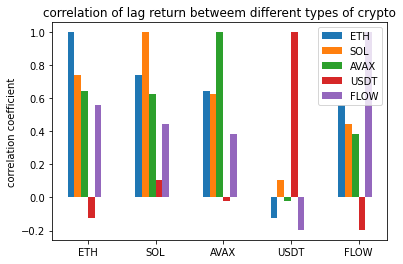

In [96]:
#question 6:visualize the correlation in a matplpotlib plot
import matplotlib.pyplot as plt
x = np.arange(len(corr))
width = 0.1
for i in range(len(corr)):
    plt.bar(x+width*i,height=corr.iloc[i],width=0.1,label=corr.index[i])
    
plt.legend()
plt.xticks(x+len(corr)/2*width,corr.index)
plt.ylabel('correlation coefficient')
plt.title('correlation of lag return betweem different types of crypto')
